In [1]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [90]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [232]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "z5hrto4y"


In [233]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [234]:
data = []
filename = f"moebius_sweep_data_{SWEEP_ID}.csv"
max_dim = -1
if not isfile(filename):
    for run in sweep_runs:

        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary = run.summary._json_dict

        if "epoch" in summary.keys() and summary["epoch"] >=180:
                #or (run.state == 'finished' or ('decoder_var' in run.config.keys() and run.config['decoder_var']>= 0.1)) and f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config = {k: v for k,v in run.config.items()
                 if not k.startswith('_')}

            dim = config['latent_dim']
            sigmas = run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(dim)]).iloc[-1].to_numpy()[1:]
            col_norms_sq = [run.summary._json_dict[f"Metrics/val/col_norm_{i}"]**2 for i in range(dim)]

            mcc = summary['Metrics/val/mcc']
            mcc_history = run.history(keys=[f'Metrics/val/mcc'])
            max_mcc_step, max_mcc = mcc_history.idxmax()[1], mcc_history.max()[1]


            cima = summary['Metrics/val/cima']
            cima_history = run.history(keys=[f'Metrics/val/cima'])
            min_cima_step, min_cima = cima_history.idxmin()[1], cima_history.min()[1]

            mcc4min_cima = mcc_history.iloc[int(min_cima_step)]['Metrics/val/mcc']
            cima4max_mcc = cima_history.iloc[int(max_mcc_step)]['Metrics/val/cima']

            gamma_square = 1. / config['decoder_var']
            prior = config['model.prior']

            neg_elbo = summary['Metrics/val/neg_elbo']
            neg_elbo_history = run.history(keys=[f'Metrics/val/neg_elbo'])
            min_neg_elbo_step, min_neg_elbo =  neg_elbo_history.idxmin()[1], neg_elbo_history.min()[1]

            mcc4min_neg_elbo = mcc_history.iloc[int(min_neg_elbo_step)]['Metrics/val/mcc']
            cima4min_neg_elbo = cima_history.iloc[int(min_neg_elbo_step)]['Metrics/val/cima']

            rec_loss = summary['Metrics/val/rec_loss']
            kl_loss = summary['Metrics/val/kl_loss']
            rhs = (1./(float(prior=="gaussian")+gamma_square*np.array(col_norms_sq)))
            if dim > max_dim:
                max_dim = dim

            data.append([run.name, dim, gamma_square, neg_elbo, kl_loss, rec_loss, prior, cima, mcc, min_cima, min_cima_step, cima4max_mcc, cima4min_neg_elbo,
                         max_mcc, max_mcc_step, mcc4min_cima, mcc4min_neg_elbo,  *sigmas, *col_norms_sq, *rhs])


    runs_df = pd.DataFrame(data, columns=["name", "dim", "gamma_square", "neg_elbo", "kl_loss", "rec_loss", "prior", "cima", "mcc", "min_cima", "min_cima_step",  "cima4max_mcc", "cima4min_neg_elbo", "max_mcc", "max_mcc_step",  "mcc4min_cima", "mcc4min_neg_elbo", *[f"sigma_{i}" for i in range(max_dim)],
                                          *[f"col_norm_sq_{i}" for i in range(max_dim)], *[f"rhs_{i}" for i in range(max_dim)]  ] ).fillna(0)
    # runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [235]:
runs_df

,name,dim,gamma_square,neg_elbo,kl_loss,rec_loss,prior,cima,mcc,min_cima,...,mcc4min_neg_elbo,sigma_0,sigma_1,sigma_2,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,rhs_0,rhs_1,rhs_2
0,peach-sweep-149,3,1000000.0,-1.830643,-13.625281,15.455926,gaussian,0.002447,0.786943,0.002447,...,0.780887,0.000032,0.000028,0.000013,0.031618,0.036450,0.079635,0.000032,0.000027,0.000013
1,summer-sweep-148,3,1000000.0,-0.789714,-14.224104,15.013820,gaussian,0.017909,0.779933,0.017909,...,0.779446,0.000009,0.000019,0.000035,0.115656,0.051917,0.029330,0.000009,0.000019,0.000034
2,woven-sweep-146,3,1000000.0,-2.592894,-11.806549,14.399443,gaussian,0.001386,0.874024,0.001386,...,0.874149,0.000015,0.000020,0.000009,0.064301,0.049834,0.111959,0.000016,0.000020,0.000009
3,laced-sweep-145,3,1000000.0,-3.097350,-12.422624,15.519972,gaussian,0.001489,0.801571,0.000874,...,0.801827,0.000014,0.000023,0.000045,0.069176,0.044936,0.021647,0.000014,0.000022,0.000046
4,elated-sweep-144,3,10.0,-0.657720,-0.000007,0.657727,gaussian,1.404431,0.057718,0.231318,...,0.057241,0.471657,0.239440,0.203540,0.000011,0.000017,0.000014,0.999890,0.999827,0.999863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,icy-sweep-21,3,10000000.0,2.854864,-19.496193,16.641328,gaussian,0.181296,0.660679,0.181296,...,0.656417,0.000001,0.000003,0.000001,0.082229,0.031206,0.091377,0.000001,0.000003,0.000001
144,eager-sweep-20,3,10000000.0,0.150864,-18.791946,18.641080,gaussian,0.070250,0.955443,0.013581,...,0.955443,0.000001,0.000003,0.000001,0.097097,0.034967,0.080638,0.000001,0.000003,0.000001
145,vocal-sweep-19,3,1000000.0,0.267476,-14.809995,14.542519,gaussian,0.008929,0.691305,0.008929,...,0.691593,0.000015,0.000015,0.000015,0.064468,0.068604,0.068598,0.000016,0.000015,0.000015
146,dandy-sweep-18,3,1000000.0,-1.652508,-13.933839,15.586348,gaussian,0.006254,0.861100,0.005839,...,0.860518,0.000021,0.000021,0.000036,0.047117,0.048213,0.027143,0.000021,0.000021,0.000037


$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [239]:
runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square").describe()

mcc                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  19.0  0.053544  0.002932  0.048861  0.051712  0.052592   
1.000000e+03  19.0  0.651958  0.073934  0.537665  0.567786  0.682387   
1.000000e+04  19.0  0.804703  0.095310  0.660606  0.738207  0.779193   
1.000000e+05  19.0  0.825038  0.080022  0.685043  0.759150  0.827510   
1.000000e+06  16.0  0.827336  0.083264  0.691305  0.776320  0.842211   
1.000000e+07  18.0  0.817810  0.086885  0.660679  0.755135  0.828853   
1.000000e+08  19.0  0.817258  0.090130  0.652155  0.736600  0.828053   
1.000000e+10  19.0  0.819243  0.090641  0.652677  0.754926  0.829415   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.056317  0.058308  
1.000000e+03  0.717294  0.740419  
1.000000e+04  0.874936  0.951662  
1.000000e+05  0.880262  0.957422  
1.000000e+06  0.878258  0.966902  
1.000000e+07  0.878897  0.955443  
1.000000e+08  0.874930  0.959077  
1.000000e+10  0.875712  0.947915

In [240]:
runs_df[[ "max_mcc", "gamma_square"]].groupby("gamma_square").describe()

max_mcc                                                    \
               count      mean       std       min       25%       50%   
gamma_square                                                             
1.000000e+01    19.0  0.060694  0.002011  0.057550  0.059215  0.060721   
1.000000e+03    19.0  0.681775  0.067921  0.563657  0.618223  0.721642   
1.000000e+04    19.0  0.814706  0.093298  0.663129  0.754368  0.794485   
1.000000e+05    19.0  0.829724  0.078259  0.690243  0.764691  0.830704   
1.000000e+06    16.0  0.828330  0.083021  0.692047  0.776320  0.842211   
1.000000e+07    18.0  0.819358  0.087332  0.660679  0.755135  0.828853   
1.000000e+08    19.0  0.818766  0.090070  0.652155  0.736600  0.828053   
1.000000e+10    19.0  0.820824  0.090378  0.652677  0.754926  0.829415   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.061579  0.065015  
1.000000e+03  0.738738  0.754540  
1.000000e+04  0.886120  0.952010  
1.000000e+05  0.880450  0.957422  
1.000000e+06  0.878673  0.966902  
1.000000e+07  0.885281  0.955443  
1.000000e+08  0.880557  0.959077  
1.000000e+10  0.881275  0.947915

In [241]:
runs_df[[ "cima", "gamma_square"]].groupby("gamma_square").describe()

cima                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  19.0  1.771367  0.873550  0.325387  1.212503  1.614037   
1.000000e+03  19.0  0.001890  0.000801  0.000395  0.001545  0.001897   
1.000000e+04  19.0  0.000426  0.000197  0.000111  0.000300  0.000396   
1.000000e+05  19.0  0.000203  0.000112  0.000021  0.000128  0.000186   
1.000000e+06  16.0  0.009978  0.010447  0.000510  0.001463  0.007742   
1.000000e+07  18.0  0.085250  0.063821  0.009724  0.034436  0.071082   
1.000000e+08  19.0  0.106444  0.073904  0.009688  0.046875  0.086382   
1.000000e+10  19.0  0.107466  0.071843  0.002147  0.050355  0.091960   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  2.214844  3.987740  
1.000000e+03  0.002629  0.002993  
1.000000e+04  0.000515  0.000947  
1.000000e+05  0.000283  0.000405  
1.000000e+06  0.014208  0.040693  
1.000000e+07  0.109357  0.223481  
1.000000e+08  0.166772  0.236785  
1.000000e+10  0.158525  0.238764

In [242]:
runs_df[[ "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

cima4min_neg_elbo                                          \
                         count      mean       std       min       25%   
gamma_square                                                             
1.000000e+01              19.0  1.545405  0.933735  0.165180  0.827417   
1.000000e+03              19.0  0.002031  0.001190  0.000241  0.001125   
1.000000e+04              19.0  0.000411  0.000206  0.000125  0.000230   
1.000000e+05              19.0  0.000280  0.000316  0.000027  0.000102   
1.000000e+06              16.0  0.014223  0.011635  0.001306  0.005135   
1.000000e+07              18.0  0.094223  0.070879  0.009797  0.038266   
1.000000e+08              19.0  0.112839  0.079339  0.009688  0.046968   
1.000000e+10              19.0  0.113707  0.077794  0.002113  0.053708   

                                            
                   50%       75%       max  
gamma_square                                
1.000000e+01  1.547086  2.122536  3.987740  
1.000000e+03  0.001662  0.002676  0.004639  
1.000000e+04  0.000378  0.000599  0.000782  
1.000000e+05  0.000168  0.000347  0.001355  
1.000000e+06  0.011693  0.021433  0.042430  
1.000000e+07  0.071082  0.116812  0.234292  
1.000000e+08  0.088836  0.181547  0.250752  
1.000000e+10  0.093954  0.160807  0.258801

In [243]:
runs_df[[ "mcc4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

mcc4min_neg_elbo                                          \
                        count      mean       std       min       25%   
gamma_square                                                            
1.000000e+01             19.0  0.054727  0.002953  0.049051  0.052326   
1.000000e+03             19.0  0.664221  0.076761  0.534897  0.586035   
1.000000e+04             19.0  0.805439  0.095644  0.658847  0.739548   
1.000000e+05             19.0  0.824611  0.079529  0.684992  0.757624   
1.000000e+06             16.0  0.825755  0.084106  0.691593  0.773675   
1.000000e+07             18.0  0.816607  0.087386  0.656417  0.755135   
1.000000e+08             19.0  0.816243  0.090433  0.650774  0.733303   
1.000000e+10             19.0  0.818276  0.090933  0.649168  0.753428   

                                            
                   50%       75%       max  
gamma_square                                
1.000000e+01  0.054784  0.056647  0.061716  
1.000000e+03  0.699416  0.726304  0.754540  
1.000000e+04  0.783261  0.874165  0.951662  
1.000000e+05  0.827510  0.878103  0.956856  
1.000000e+06  0.840808  0.878379  0.966253  
1.000000e+07  0.825555  0.880593  0.955443  
1.000000e+08  0.825707  0.875169  0.958491  
1.000000e+10  0.826408  0.875978  0.947120

In [244]:
runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

neg_elbo                                                     \
                count         mean          std         min          25%   
gamma_square                                                               
1.000000e+01     19.0    -0.657954     0.000194   -0.658188    -0.658092   
1.000000e+03     19.0    -4.751997     0.017001   -4.774455    -4.765416   
1.000000e+04     19.0    -4.674331     0.098136   -4.789461    -4.753610   
1.000000e+05     19.0    -4.084388     0.457678   -4.607050    -4.366480   
1.000000e+06     16.0    -1.355576     1.579141   -3.856509    -2.501974   
1.000000e+07     18.0     6.128878     5.823205   -2.629956     2.249966   
1.000000e+08     19.0    44.350171    43.721035    2.882845    12.798615   
1.000000e+10     19.0  6360.511878  5145.303769  583.680076  1901.246390   

                                                       
                      50%           75%           max  
gamma_square                                           
1.000000e+01    -0.657964     -0.657856     -0.657602  
1.000000e+03    -4.754372     -4.744926     -4.712541  
1.000000e+04    -4.674776     -4.636056     -4.363001  
1.000000e+05    -4.205534     -3.926297     -3.005462  
1.000000e+06    -1.654716     -0.525416      1.499911  
1.000000e+07     4.715970     10.555530     17.416092  
1.000000e+08    30.672712     55.651137    172.432388  
1.000000e+10  5137.261631  10631.301507  15485.804276

In [245]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [246]:
def create_violinplot(groups, xlabel, ylabel, xticklabels, figsize=(6,3), filename=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    vp= plt.violinplot(groups, showmedians=True)
    for el in vp['bodies']:
        el.set_facecolor('#1A85FF')
        el.set_edgecolor('black')
        el.set_linewidth(1.5)
        el.set_alpha(.9)
    for pn in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        vp_ = vp[pn]
        vp_.set_edgecolor('black')
        vp_.set_linewidth(1)
    ax.set_xticklabels(xticklabels)
    # plt.locator_params(axis='y', nbins=5)
    # plt.yticks(fontsize=24)
    # plt.ylim([0, 0.5])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if filename is not None:
        plt.savefig(f"{filename}.svg")

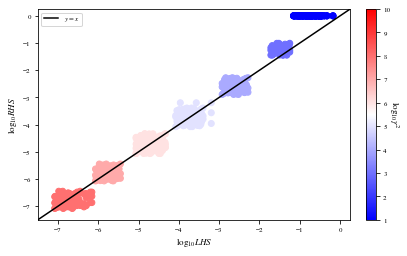

In [334]:
#todo: plot mean/median
plt.scatter(np.log10(df_rhs_lhs_gamma_sq.lhs), np.log10(df_rhs_lhs_gamma_sq.rhs), c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap='bwr')
plt.plot(np.linspace(-7.5, 0.25), np.linspace(-7.5, 0.25), c="black", label='$y=x$')
plt.ylabel('$\log_{10} RHS$')
plt.xlabel('$\log_{10} LHS$')
plt.ylim([-7.5, .25])
plt.xlim([-7.5, .25])
plt.legend()
cbar = plt.colorbar()
# cbar.ax.set_yticklabels(['0','1','2','>3'])
cbar.set_label('$\log_{10}\gamma^2$', rotation=270)
cbar.ax.get_yaxis().labelpad = 10
plt.savefig("rhs_lhs.svg")

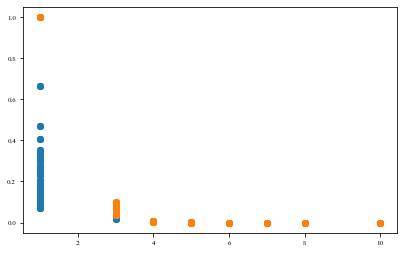

In [333]:
plt.scatter(np.log10(df_rhs_lhs_gamma_sq.gamma_square),df_rhs_lhs_gamma_sq.lhs)# c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap="bwr")
plt.scatter(np.log10(df_rhs_lhs_gamma_sq.gamma_square),df_rhs_lhs_gamma_sq.rhs)# c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap="bwr")
# cbar = plt.colorbar()

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/213047492.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


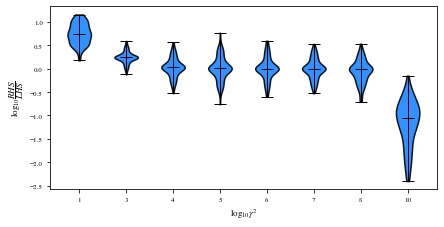

In [290]:
groups = [np.log10((g.rhs-g.lhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
create_violinplot(groups, '$\log_{10}\gamma^2$', '$\log_{10}\dfrac{RHS}{LHS}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="opt_sigma_gamma")

In [324]:
elbo_filter = runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()['neg_elbo']['25%']
groups = [g for _, g in runs_df[[ "neg_elbo", "max_mcc", "cima", "gamma_square"]].groupby("gamma_square")]
gg_mcc = [g[g.neg_elbo <= threshold].max_mcc  for g, threshold in zip(groups, elbo_filter)]
gg_cima = [g[g.neg_elbo <= threshold].cima  for g, threshold in zip(groups, elbo_filter)]
gg_gamma = [g[g.neg_elbo <= threshold].gamma_square  for g, threshold in zip(groups, elbo_filter)]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/213047492.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


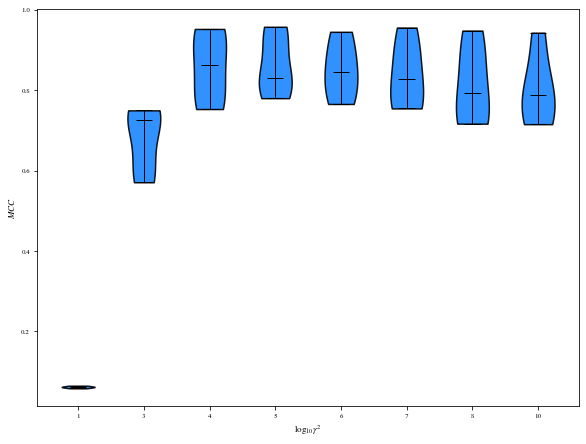

In [325]:
create_violinplot(gg_mcc, '$\log_{10}\gamma^2$', '$MCC$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="mcc_vs_gamma", figsize=(8,6))

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/213047492.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


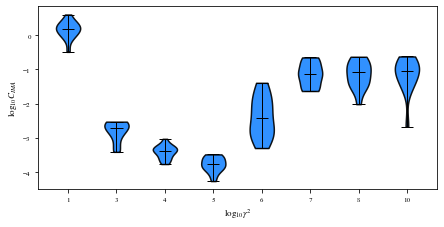

In [250]:
create_violinplot([np.log10(g) for g in gg_cima], '$\log_{10}\gamma^2$', '$\log_{10}C_{IMA}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="cima_vs_gamma")

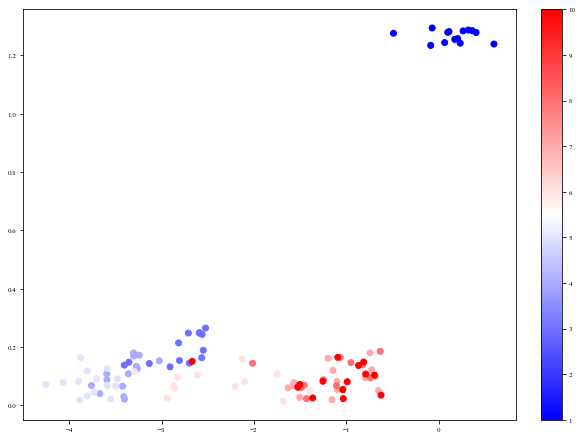

In [313]:
plt.figure(figsize=(8,6))
plt.scatter([np.log10(item) for sublist in gg_cima for item in sublist],[-np.log10(item) for sublist in gg_mcc for item in sublist], c=[np.log10(item) for sublist in gg_gamma for item in sublist], cmap="bwr")
plt.colorbar()

In [286]:
larger_gamma_df = runs_df[runs_df['gamma_square']>100]

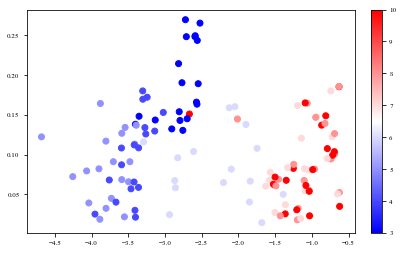

In [317]:
plt.scatter(np.log10(larger_gamma_df['cima']), -np.log10(larger_gamma_df['mcc']), c=np.log10(larger_gamma_df['gamma_square']), cmap='bwr')
plt.colorbar()

In [48]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

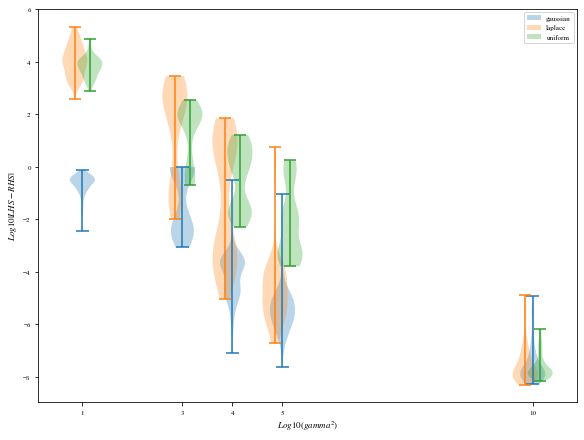

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)